# Importing Librairies


In [ ]:
import os
from os import walk

import cv2
import time

import shutil
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat

import tensorflow
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import softmax
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Accuracy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading and Processing the dataset

In [ ]:
path = "" # Please indacte the path to dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(data_path, classes, dataset='train', image_size=128):

    num_images = 0

    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Loading images
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Opening the image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # RGB conversion
                img = img.convert('RGB')
                # Resizing
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Writing the label
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

## Training set; Validation set; Test set

In [ ]:
labels = ['shikamaru', 'naruto', 'obito', 'sakura', 'sasuke']
size = 128

x_train, y_train = load_data(path, labels, dataset='train', image_size=size)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=size)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=size)
print(x_test.shape, y_test.shape)

(806, 128, 128, 3) (806, 1)
(107, 128, 128, 3) (107, 1)
(104, 128, 128, 3) (104, 1)


### Displaying examles from the training set

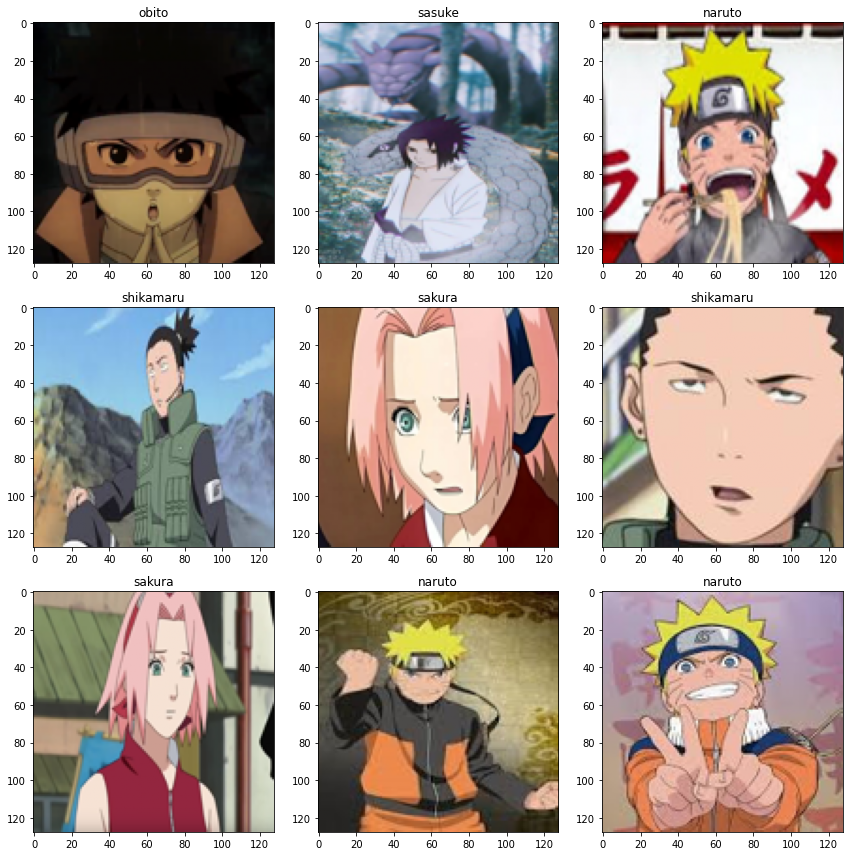

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(x_train.shape[0])
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

### [0,1] Normalization

In [ ]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

# Model

## Architecture

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=(size,size,3), padding ="valid"))
model.add(MaxPooling2D(pool_size = (2,2), padding="valid"))

model.add(Conv2D(64, (3,3), activation="relu",  padding ="valid"))
model.add(MaxPooling2D(pool_size = (2,2), padding="valid"))

model.add(Conv2D(96, (3,3), activation="relu",padding ="valid"))
model.add(MaxPooling2D(pool_size = (2,2), padding="valid"))

model.add(Conv2D(128, (3,3), activation="relu",  padding ="valid"))
model.add(MaxPooling2D(pool_size = (2,2), padding="valid"))

model.add(Flatten()) 
model.add(Dense(512, activation="relu"))
model.add(Dense(5, activation="softmax") )

## Model summary

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 96)        55392     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 96)      

# Training

In [ ]:
lr = 3e-4
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['sparse_categorical_accuracy'])

# Callbacks

# Best weights (validation set)
checkpoint_filepath = 'best_weights'
mc_cb = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# Early Stopping
es_cb = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=7,
    mode="auto")

history = model.fit(x_train,y_train, 
                    validation_data=(x_val, y_val),
                    epochs=100,
                    callbacks = [mc_cb, es_cb]
                    )

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.5280 - sparse_categorical_accuracy: 0.3077
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.42991, saving model to best_weights
26/26 [==============================] - 13s 66ms/step - loss: 1.5280 - sparse_categorical_accuracy: 0.3077 - val_loss: 1.4260 - val_sparse_categorical_accuracy: 0.4299
Epoch 2/100
25/26 [===========================>..] - ETA: 0s - loss: 1.1901 - sparse_categorical_accuracy: 0.5013
Epoch 2: val_sparse_categorical_accuracy improved from 0.42991 to 0.67290, saving model to best_weights
26/26 [==============================] - 1s 43ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.6729
Epoch 3/100
25/26 [===========================>..] - ETA: 0s - loss: 0.9762 - sparse_categorical_accuracy: 0.6187
Epoch 3: val_sparse_categorical_accuracy improved from 0.67290 to 0.71963, saving model to best_weights
26/26 [=====

In [ ]:
model.load_weights('best_weights')

In [ ]:
def plot_training_analysis():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

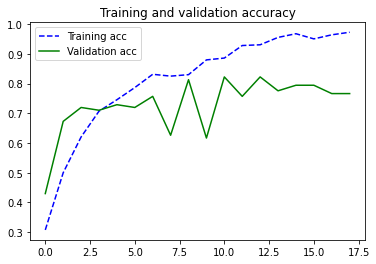

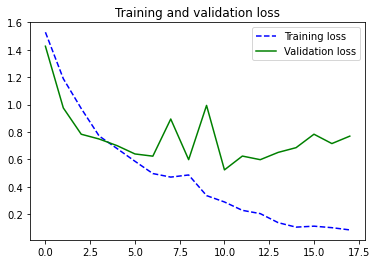

In [ ]:
plot_training_analysis()

In [ ]:
test_accuracy = Accuracy()

# training=False is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
logits = model(x_test, training=False)
prediction = tensorflow.argmax(logits, axis=1, output_type=tensorflow.int32)
test_accuracy(prediction, y_test)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))